In [93]:
%matplotlib notebook  

import codecs
import random
import collections

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 

import nltk
from gensim import corpora, models, similarities
from bs4 import BeautifulSoup

In [2]:
g = nx.read_gexf("datasets/influences.gexf")

In [3]:
corpus_entries = g.nodes()
random.shuffle(corpus_entries)
# corpus_entries = corpus_entries[0:1000]

In [4]:
stopwords = codecs.open("datasets/stopwords.final.txt", "r", "utf-8").read().split()

def load(name):
  txt = codecs.open("datasets/pages/%s.html" % name.replace("/", "-"),"r", "utf-8-sig").read()

  txt = BeautifulSoup(txt, "html.parser")
  txt = txt.get_text()
  
  return txt

def tokenize(doc):
  #text_tagged = nltk.pos_tag(nltk.word_tokenize(doc))
  words = doc.lower().split()

  #remove stopwords
  words = [ w for w in words if w not in stopwords ]
  #text_tagged = [ (w,t) for (w,t) in text_tagged if w not in stopwords ]
  
  counter = collections.Counter(words)
  
  tokens = [ w for w in counter if counter[w] > 5 ]

  return tokens
  
  
def process(name):
  txt = load(name)
  doc = tokenize(txt)
  
  return doc

corpus = [ process(name) for name in corpus_entries ]

In [5]:
dictionary = corpora.Dictionary(corpus)
print dictionary

Dictionary(24621 unique tokens: [u'schlegel', u'woods', u'francesco', u'1-55546-855-1.', u'jamiat']...)


In [9]:
training = [dictionary.doc2bow(doc) for doc in corpus]
# bigrams = models.Phrases(corpus)

lda = models.ldamodel.LdaModel(corpus=training, id2word=dictionary, num_topics=250, passes=20)

In [10]:
lda.save("datasets/lda-250topics.mm")

## Visualization

In [54]:
philosophers_lda250 = pd.DataFrame(index=corpus_entries, columns=[ "lda_%s" % i for i in range(0,250) ])

def project(name):
  x = lda[dictionary.doc2bow(process(name))]
  
  if len(x)>0:
    (topics, values) = zip(*[ ("lda_%s" % t, v) for (t,v) in x ])
    philosophers_lda250.loc[name, topics] = values

#[ project(d) for d in ["Ludwig_Wittgenstein", "Meister_Eckhart"] ];
map(lambda name: project(name), philosophers_lda250.index)

philosophers_lda250 = philosophers_lda250.fillna(0)

philosophers_lda250.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,...,lda_240,lda_241,lda_242,lda_243,lda_244,lda_245,lda_246,lda_247,lda_248,lda_249
Meister_Eckhart,0.0,0.0,0.0,0.0,0.2922,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Onora_O'Neill,_Baroness_O'Neill_of_Bengarve",0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eric_Dunning,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H._G._Wells,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bronisław_Malinowski,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
philosophers_lda250.to_csv("datasets/lda250.csv", encoding="utf-8")

In [85]:
M = philosophers_lda250.as_matrix()

In [86]:
pca = PCA()

Z = pca.fit(M).transform(M)
Z = zip(*Z)

<IPython.core.display.Javascript object>


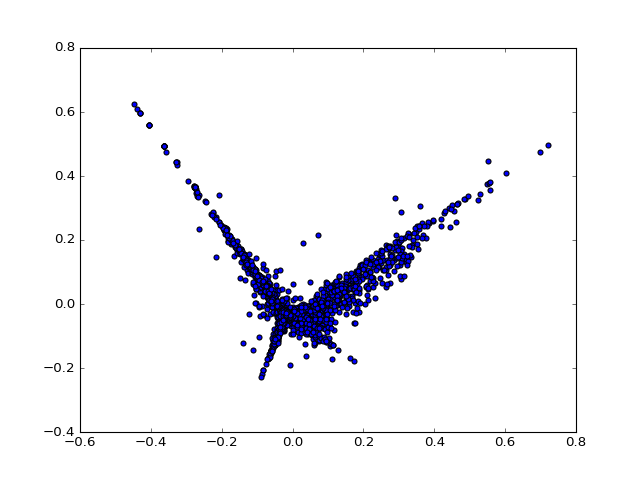

In [96]:
fig = plt.figure()
plt.scatter(Z[0], Z[1])

plt.show()

In [97]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=15, random_state=170).fit_predict(M)

<IPython.core.display.Javascript object>


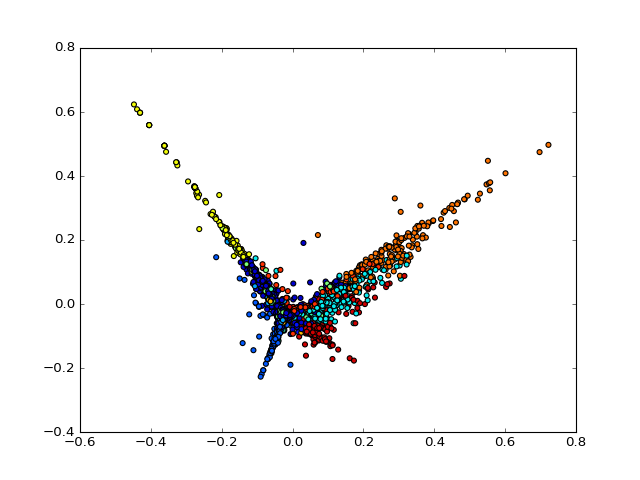

In [99]:
fig = plt.figure()
plt.scatter(Z[0], Z[1], c=y_pred)

plt.show()

250


<IPython.core.display.Javascript object>


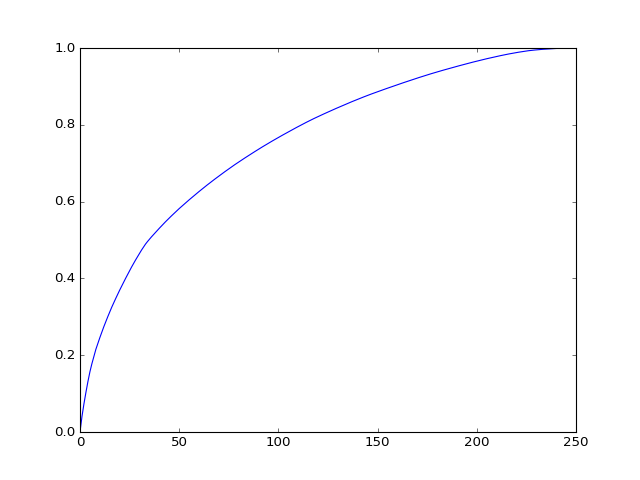

In [94]:
print len(pca.explained_variance_ratio_)

def plot_explained_vr(pca):
  (x, y) = zip(*list(enumerate(pca.explained_variance_ratio_)))
  
  y = [ np.sum(y[0:i]) for i, dummy in enumerate(y) ]
  
  fig = plt.figure()
  plt.plot(x, y)
  
  plt.show()

plot_explained_vr(pca)

<IPython.core.display.Javascript object>


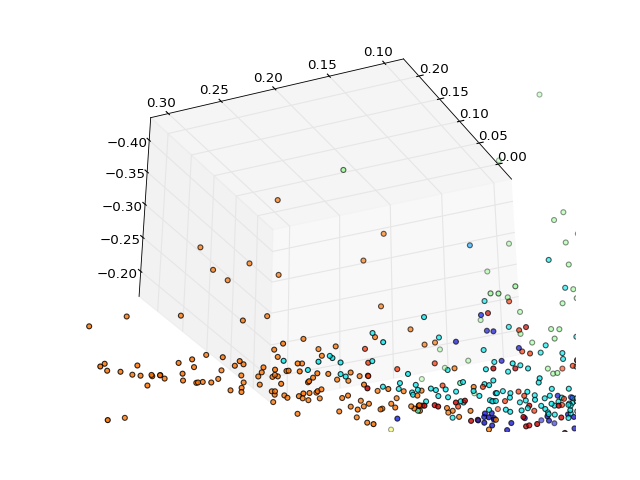

In [100]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Z[0], Z[1], Z[2], c=y_pred)

plt.show()